In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# configs and hyperparameters
BATCH_SIZE = 2048
LEARNING_RATE = 0.001
EPOCHS = 30
INPUT_SHAPE = 784

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Found GPU: {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device("cpu")
    print("⚠️ GPU not found. Falling back to CPU.")

Found GPU: AMD Radeon RX 7700 XT


In [5]:
data = np.load("fashion_mnist_garments.npz")

x_garments = data["x_garments"]
y_garments = data["y_garments"]
x_others = data["x_others"]
y_others = data["y_others"]

labels_garments = np.ones((len(x_garments), 1))
labels_others = np.zeros((len(x_others), 1))

all_x = np.concatenate([x_garments, x_others], axis=0) 
all_y = np.concatenate([labels_garments, labels_others], axis=0)

x_tensor = torch.from_numpy(all_x).float()
y_tensor = torch.from_numpy(all_y).float()

print(f"Data Loaded: {x_tensor.shape}")

Data Loaded: torch.Size([70000, 28, 28])


In [6]:
class GarmentClassifier(nn.Module):
    def __init__(self, input_size=784):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),              
            nn.ReLU(),       
            nn.Linear(512, 256),
            nn.ReLU(),  
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [7]:
class Trainer:
    def __init__(self, model, learning_rate, device):
        self.model = model.to(device)
        self.device = device
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.history = []


    def train_epoch(self, train_loader):
        self.model.train()
        running_loss = 0.0
        
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)

            # 1. prediction
            preds = self.model(x_batch)

            # 2. calculate loss
            loss = self.loss_fn(preds, y_batch)

            # 3. backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        return running_loss / len(train_loader)
    
    def fit(self, train_loader, epochs):
            print(f"Starting training on {self.device}...")
            
            for epoch in range(epochs):
                avg_loss = self.train_epoch(train_loader)
                self.history.append(avg_loss)
                
                
                print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")
                    
            return self.history

In [8]:
dataset = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True, 
                        pin_memory=True,
                        num_workers=2,
                        persistent_workers=True)

model = GarmentClassifier()
trainer = Trainer(model, LEARNING_RATE, DEVICE)

history = trainer.fit(train_loader, EPOCHS)

Starting training on cuda...
Epoch 1/30 | Loss: 0.0602
Epoch 2/30 | Loss: 0.0156
Epoch 3/30 | Loss: 0.0130
Epoch 4/30 | Loss: 0.0113
Epoch 5/30 | Loss: 0.0101
Epoch 6/30 | Loss: 0.0088
Epoch 7/30 | Loss: 0.0083
Epoch 8/30 | Loss: 0.0078
Epoch 9/30 | Loss: 0.0075
Epoch 10/30 | Loss: 0.0063
Epoch 11/30 | Loss: 0.0058
Epoch 12/30 | Loss: 0.0058
Epoch 13/30 | Loss: 0.0064
Epoch 14/30 | Loss: 0.0060
Epoch 15/30 | Loss: 0.0051
Epoch 16/30 | Loss: 0.0046
Epoch 17/30 | Loss: 0.0044
Epoch 18/30 | Loss: 0.0041
Epoch 19/30 | Loss: 0.0043
Epoch 20/30 | Loss: 0.0035
Epoch 21/30 | Loss: 0.0041
Epoch 22/30 | Loss: 0.0036
Epoch 23/30 | Loss: 0.0034
Epoch 24/30 | Loss: 0.0039
Epoch 25/30 | Loss: 0.0032
Epoch 26/30 | Loss: 0.0036
Epoch 27/30 | Loss: 0.0030
Epoch 28/30 | Loss: 0.0029
Epoch 29/30 | Loss: 0.0025
Epoch 30/30 | Loss: 0.0026


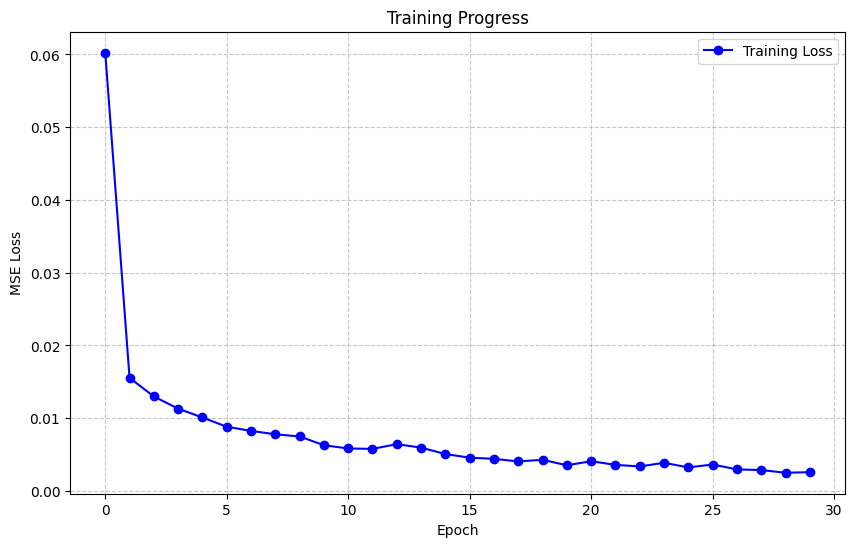

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history, 
         marker='o', 
         linestyle='-', 
         color='b', 
         label='Training Loss')
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()